In [4]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import unsupervised_library as unlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
static_plotter = optlib.static_plotter.Visualizer()
optimizers = optlib.optimizers

basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np
import numpy as npo

# import timer
from datetime import datetime 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

import matplotlib.pyplot as plt
from matplotlib import gridspec

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 12.3  Features, functions, and nonlinear unsupervised learning

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.

In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is eåxported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In this Section we introduce the general framework of nonlinear unsupervised learning. Since there are such a wide variety of unsupervised learning models (see Chapter 11), and we want to keep things as elementary as we can in this Section, here we will focus our attention exclusively on how to extend perhaps the most important linear unsupervised learner to the nonlinear setting: the PCA autoencoder (detailed in Section 11.2). In future Chapters we will look at particular examples of how to extend other unsupervised methods such as K-Means.

## 12.3.1  Modeling principles of the linear and nonlinear autoencoder

Recall the autoencoder cost function  

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2
\end{equation}

Note we can break up the term $\mathbf{C}\mathbf{C}^T\mathbf{x}_p$ into an explicit *encoding* and *decoding* step. We have our `encoder` function $f_{\text{e}}$

\begin{equation}
f_{\text{e}}\left(\mathbf{x}\right) = \mathbf{C}^T \mathbf{x}
\end{equation}

and `decoder` function $f_{\text{d}}$


\begin{equation}
f_{\text{d}}\left(\mathbf{v}\right) = \mathbf{C} \mathbf{v}
\end{equation}

Their composition evaluated at $\mathbf{x}_p$ is then given as  

\begin{equation}
f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) = \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p
\end{equation}

**Note:** for simplicity, we have left off the encoder and decoder's dependency on internal parameters. To be more accurate  we should write $f_{\text{d}}\left(\mathbf{v},\mathbf{C}\right)$ and $f_{\text{e}}\left(\mathbf{x},\mathbf{C}\right)$.

This allows us to write the autoencoder cost function more generally as

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \,f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) - \mathbf{x}_p \right\Vert_2^2
\end{equation}

This sort of mathematical notation carries over almost directly to `Python`.

**Python implementation:**

We can process the entire dataset $\mathbf{X}$ in one operation (which is more efficient in `Python` than explicitly looping over the points).

In [5]:
# a linear encoder function
def encoder(X,C):
    return np.dot(C.T,X)

# a linear decoder function
def decoder(V,C):
    return np.dot(C,V)

We can wrap up the encoder and decoder using our typical `model` function, producing $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right)$.

In [6]:
# a model function wrapping up our linear encoding/decoding schemes
def model(X,C):
    # encode the input
    V = encoder(X,C)
    
    # decode the encoding
    a = decoder(V,C)
    return a

To tune these parameters properly we can then minimize the `autoencoder` function below using e.g., gradient descent.

In [7]:
# an implementation of the least squares cost function for linear regression
def autoencoder(C):
    cost = np.sum((model(X,C) - X)**2)
    return cost/float(X.shape[1])

#### <span style="color:#a50e3e;">Example 1. </span> Linear PCA using the autoencoder 

Here we re-enact an experiment showing how to use the standard linear autoencoder first shown in Section 11.4, employing the organizatinoal style detailed above, to find the best one dimensional subspace for the two dimensional dataset shown below.

<IPython.core.display.Javascript object>


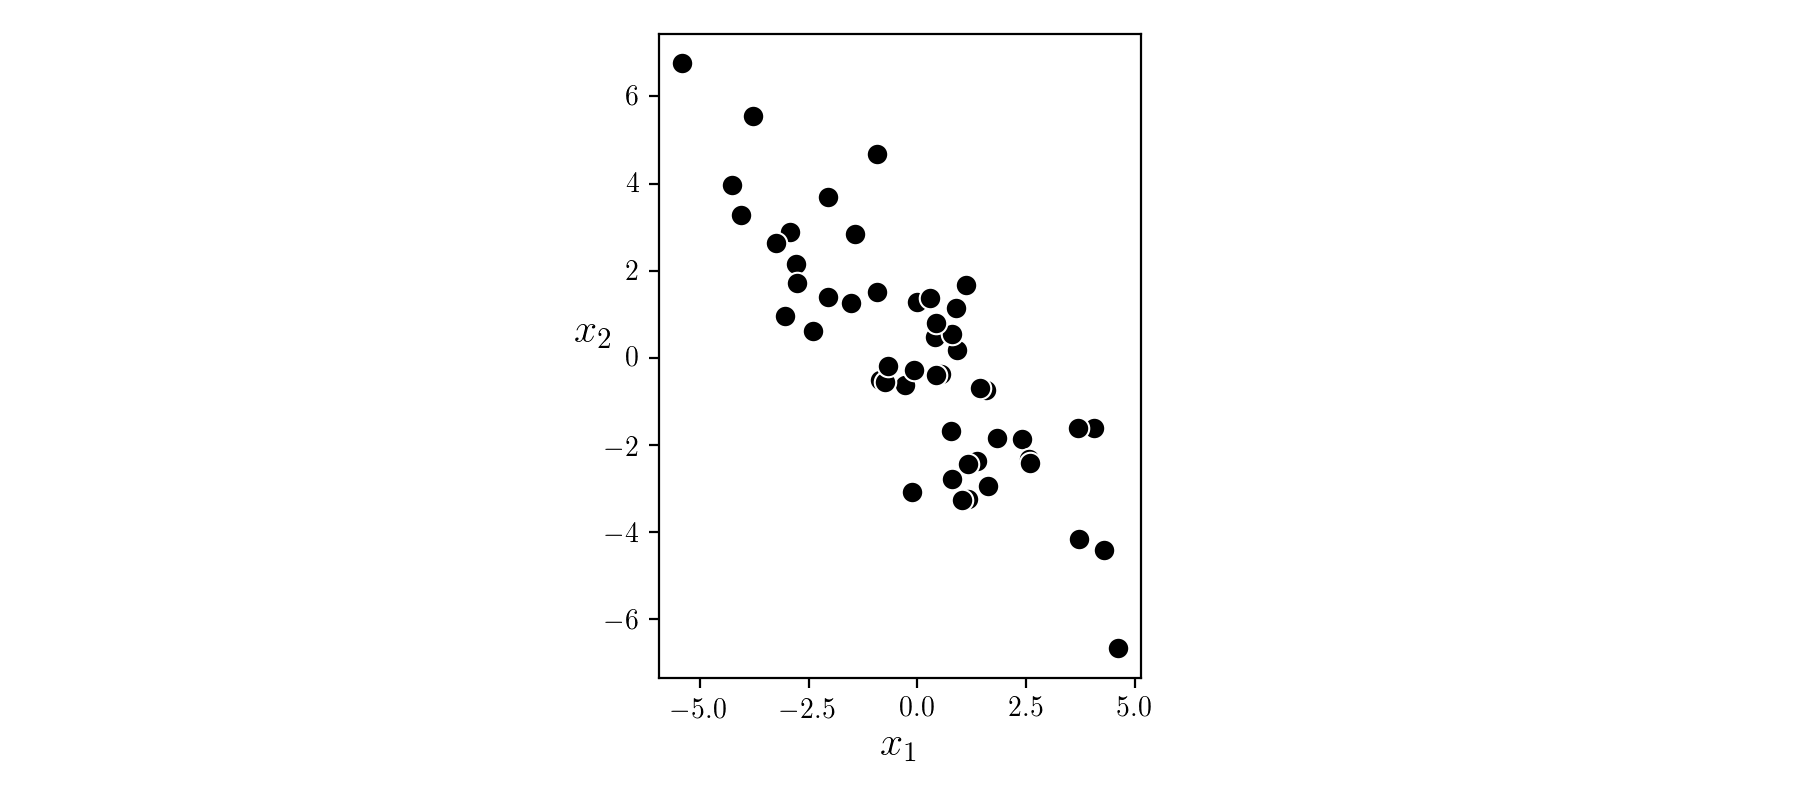

In [8]:
# load in a dataset to learn a PCA basis for via the autoencoder
X = np.loadtxt(datapath + '2d_span_data_centered.csv',delimiter=',')

# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w');

In visually examining this dataset it does indeed look like it could be reasonably represented using a *linear* manifold or subspace (which in this case is clearly a line).  Because of this we can use our linear `encoder` and `decoder` functions defined above.

Using gradient descent we then minimize the autoencoder cost, finding the best one dimensional subspace for this two-dimensional dataset.

In [9]:
# tune the autoencoder via gradient descent
g = autoencoder; alpha_choice = 10**(-2); max_its = 1000; C = 0.1*np.random.randn(2,1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,C)

Shown below in the top row is (left panel) the original data and the principal component recovered (shown as a red arrow), the encoded version (middle panel) and decoded version (right panel) of the input data along with the subspace spanned by the recovered basis vector.  In the bottom row we show the manifold recovered - as a black line with red outline for visualization purposes - and illustrate how points in the space are attracted to the recovered manifold as a vector field with arrows colored according to their distance to the linear subspace.

<IPython.core.display.Javascript object>


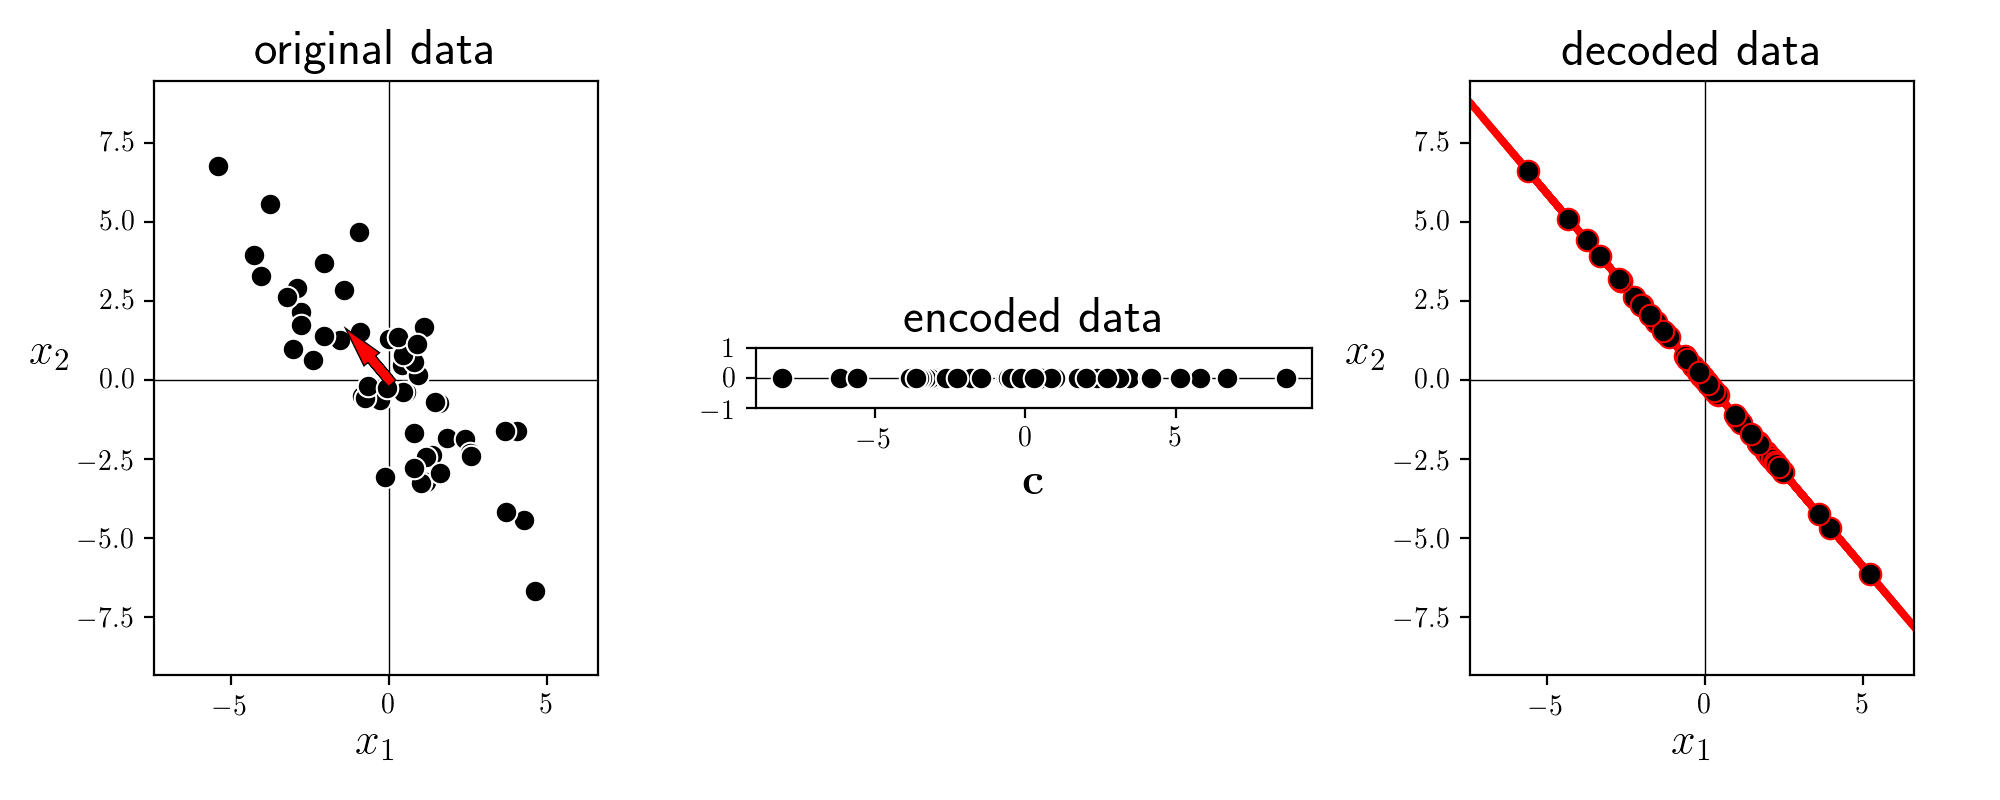

<IPython.core.display.Javascript object>


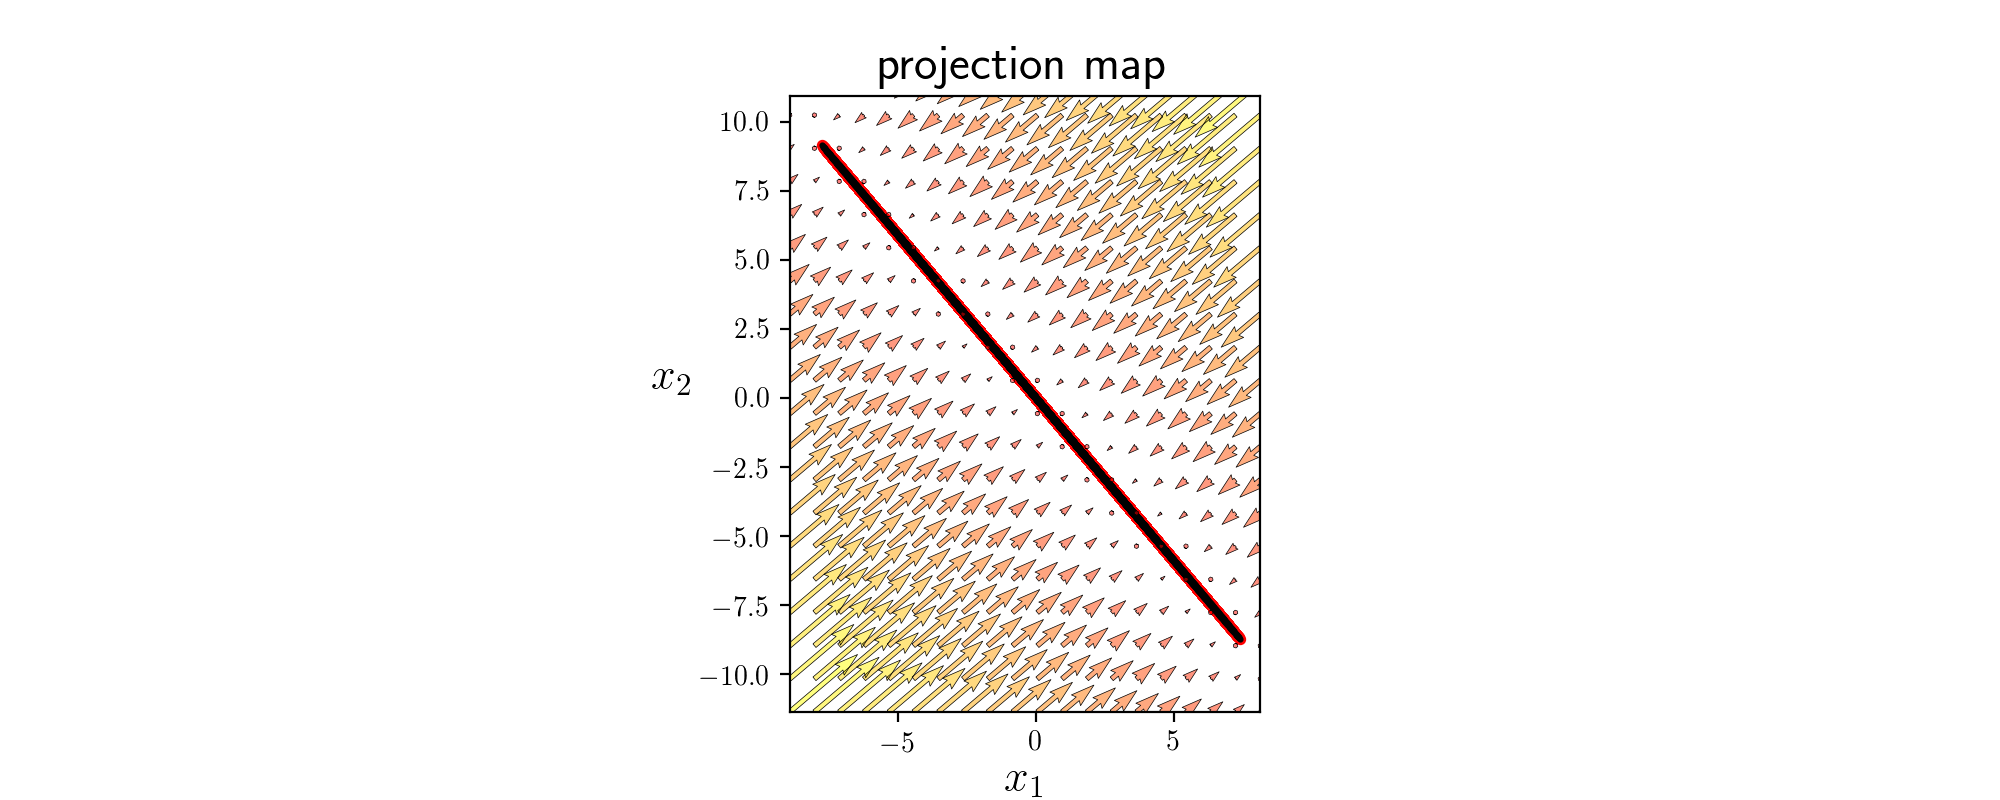

In [10]:
# plot results
unlib.autoencoder_demos.show_encode_decode(X,cost_history,weight_history,show_pc = True,scale = 150,encode_label = r'$\mathbf{c}$',projmap = True)

---

Now just as we discussed in the previous Sections, where we described how to extend linear regression and classification to the general nonlinear case, here the fact the `encoder` and `decoder` above are *linear* does not reflect a limitation of the autoencoder framework but simply *modeling choice of ours*. We (originally) aimed to uncover the best *linear* subspace for an input dataset because this is the simplest model to work with, and allows us to flush out important technical details.  However nothing about the autoencoder framework itself limits us to using *linear* encoding/decoding functions, and thus prevents us from extending the idea in order to uncover the best *nonlinear* manifold for a given set of input data.

**Nonlinear autoencoders?**

- Just like we extended linear regression/classification to nonlinear regression/classification, we can extend the autoencoder framework so that it uses nonlinear encoder and decoder instead of linear ones. 

- To make this extension we can introduce any two *parameterized* nonlinear functions: one for `encoding`  $\,\,f_{\text{e}}\left(\mathbf{x}\right)$ and one for `decoding` $ f_{\text{d}}\left(\mathbf{v}\right)$ so that again we have

\begin{equation}
f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) \approx \mathbf{x}_p
\end{equation}

We can still use the same autoencoder cost function

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \,f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) - \mathbf{x}_p \right\Vert_2^2
\end{equation}

where $\mathbf{w}$ denotes the entire set of parameters of both the `encoder` $f_{\text{e}}$ and `decoder` $f_\text{d}$. 

## 12.1.3  Introductory examples of nonlinear PCA via the autoencoder

**Python implementation:**

- We can virtually re-use most of the code framework we employed in the linear case.

- We only need to slightly modify the `model` function to take in a generally larger set of parameters - since each of our encoding/decoding functions can in general have unique sets of parameters.

In [8]:
# a general model wrapping up our encoder/decoder
def model(X,w):
    # encode the input
    v = encoder(X,w[0])
    
    # decode the encoding
    a = decoder(v,w[1])
    return a

In short, to use the nonlinear autoencoder we need only define `encoder` and `decoder` functions, since the above `autoencoder` cost function implementation is always the same regardless of the dataset/nonlinearities used and `model` functions will always be more or less the same.

In [9]:
# an implementation of the least squares cost function for linear regression
def autoencoder(w):
    cost = np.sum((model(X,w) - X)**2)
    return cost/float(X.shape[1])

#### <span style="color:#a50e3e;">Example 2. </span> Finding a circular subspace via the autoencoder

In this example we use a simulated dataset of $P=20$ two-dimensional data points to learn a circular manifold via our nonlinear autoencoder scheme. The Python cell below plots the data - which as you can see - has an almost circular shape but not all of the data points fall precisely on a circle (due to noise).

<IPython.core.display.Javascript object>


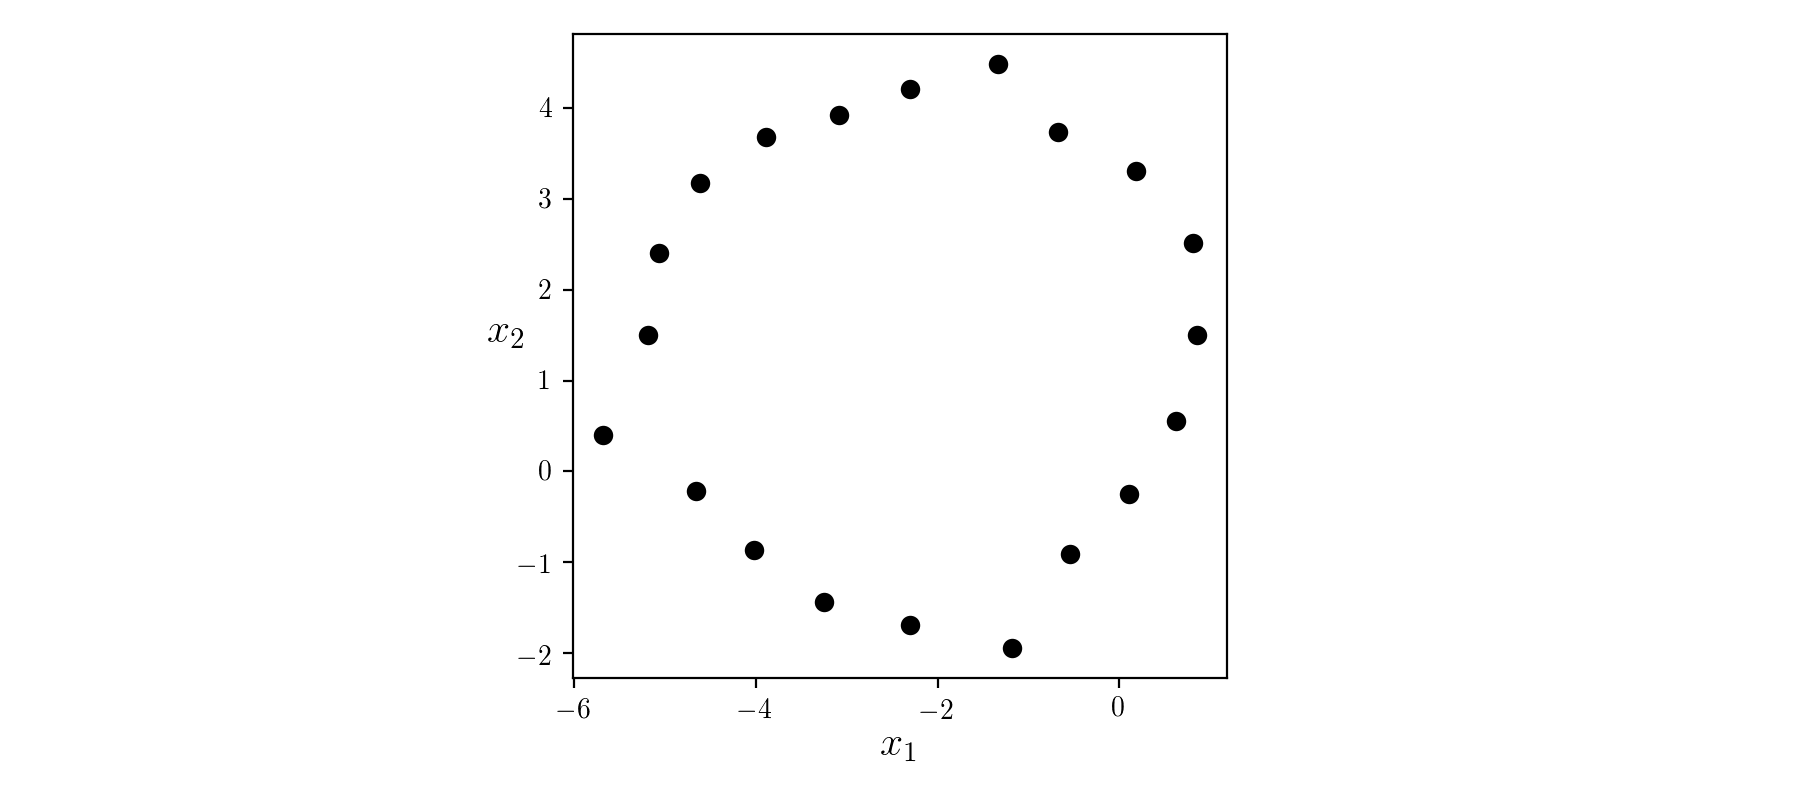

In [10]:
# import data
X = np.loadtxt(datapath + 'circle_data.csv',delimiter=',')

# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
plt.show()

**Encoder design:** 
- We subtract off $\mathbf{w}$ from any $\mathbf{x}_p$ in the dataset. This centers the circle around the origin. 
- Using the arctan function we can then find the angle $\theta_p$ - this is the encoded version of $\mathbf{x}_p$.

<figure>
<img src="../../mlrefined_images/unsupervised_images/autoencoder_circle.png" width="100%" height="auto"/>
</figure>

Once centered, any two-dimensional data point $\mathbf{x}_p-\mathbf{w}$ on the circle can be encoded as the (scalar) angle $\theta_p$ between the line segment connecting it to the origin and the horizontal axis. Mathematically speaking we have

\begin{equation}
\theta_p=\text{arctan}\left(\frac{x_
{p,2}-w_2}{x_{p,1}-w_1}\right)
\end{equation}

This is our nonlinear encoder which we implement below along with our custom ``arctan`` function.

In [11]:
def my_arctan(x1,x2):
    v = x2/x1
    if x1 > 0:
        return np.arctan(v)
    elif x1 < 0 and x2 >= 0:
        return np.arctan(v) + np.pi
    elif x1 < 0 and x2 < 0:
        return np.arctan(v) - np.pi
    elif x1==0 and x2 > 0:
        return np.pi*0.5
    elif x1==0 and x2 < 0:
        return -np.pi*0.5  
    
def encoder(x,w):
    a = x - w     
    b = []
    for i in range(a.shape[1]):
        b.append(my_arctan(a[0][i],a[1][i]))
    b = np.array(b)[np.newaxis,:]
    return b      

To design the decoder, beginning with $\theta_p$, we can reconstruct $\mathbf{x}_p$ as

\begin{equation}
\mathbf{x}_p=\left[\begin{array}{c}
r_1\,\text{cos}(\theta_p)+w_1\\
r_2\,\text{sin}(\theta_p)+w_2
\end{array}\right]
\end{equation}

The ``decoder`` function below implements this nonlinear decoding process. 

**Decoder design:**

- beginning with $\theta_p$ as the encoded version of $\mathbf{x}_p$ we form the vector $\left[\begin{array}{c}
r_1\,\text{cos}(\theta_p)\\
r_2\,\text{sin}(\theta_p)
\end{array}\right]$ where we use potentially different parameters $r_1$ and $r_2$, in case the original data wasn't a perfect circle. 

- The decoded version of $\theta_p$ is then given by $\left[\begin{array}{c}
r_1\,\text{cos}(\theta_p)\\
r_2\,\text{sin}(\theta_p)
\end{array}\right] + \mathbf{w}$. One can reuse the same $\mathbf{w}$ learned through encoding or learn it altogther independent of the encoder. The take the latter approach.     

In [12]:
def decoder(v,w):
    a = w[:,0][:,np.newaxis]*np.vstack((np.cos(v),np.sin(v))) + w[:,1][:,np.newaxis]
    return a

Using gradient descent we can now minimize the autoencoder cost, finding the optimal encoder/decoder parameters for this dataset.

<IPython.core.display.Javascript object>


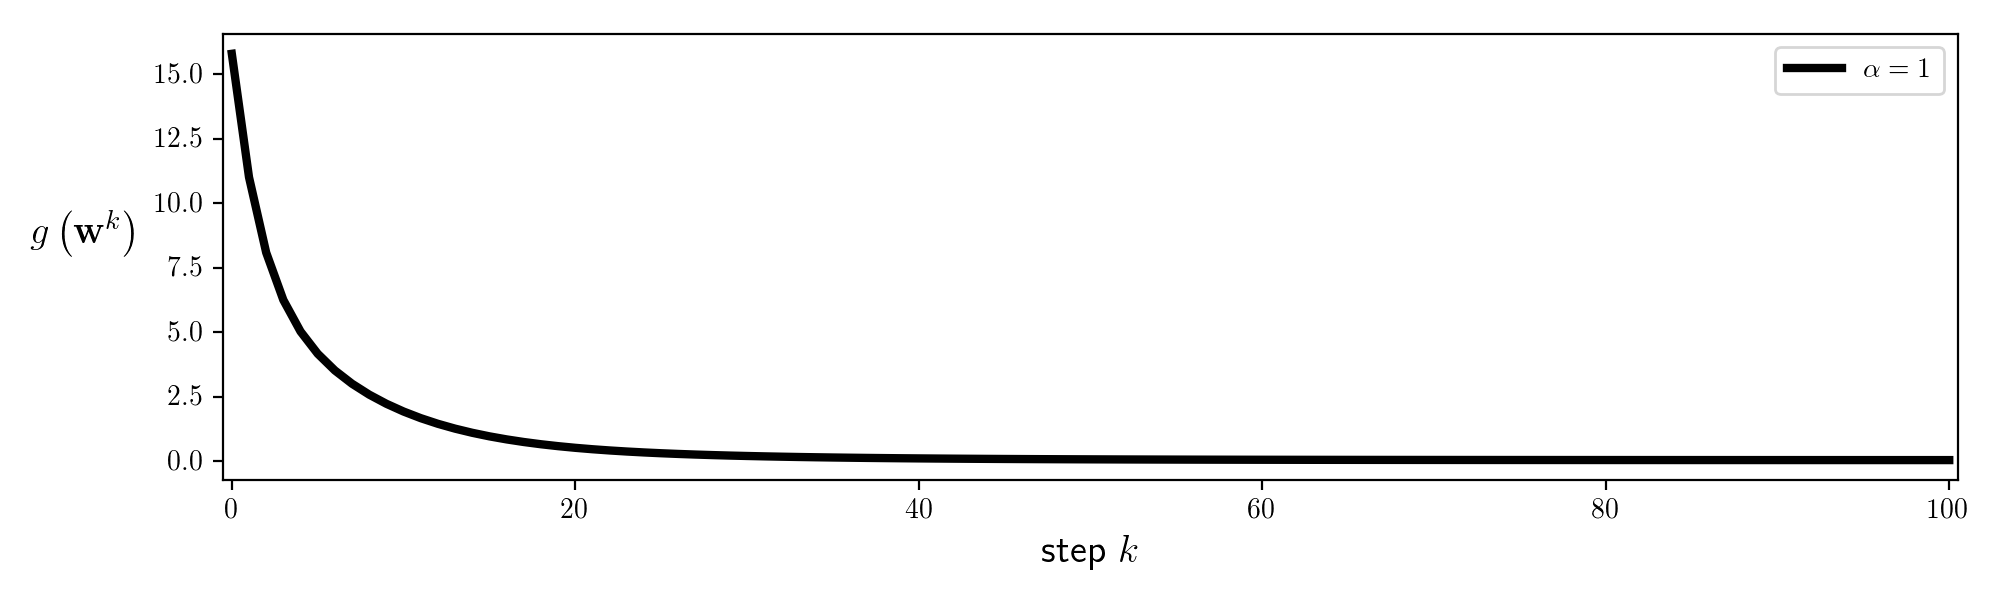

In [13]:
scale = 0.1
w = [scale*np.random.randn(2,1),scale*np.random.randn(2,2)];

# tune pca least squares cost
g = autoencoder;

# tune pca least squares cost
alpha_choice = 10**(-1); max_its = 100; 
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history],start = 0,points = False,labels = [r'$\alpha = 1$'])

Finally, shown below in the top left panel is the original data, in the top middle panel its 1-d encoded version, and in the top right panel the decoded version along with the learned nonlinear manifold (in red). In the bottom row we show the manifold recovered - as a black circle with red outline for visualization purposes - and illustrate how points in the space are attracted to the recovered manifold as a vector field with arrows colored according to their distance to the linear subspace.

<IPython.core.display.Javascript object>


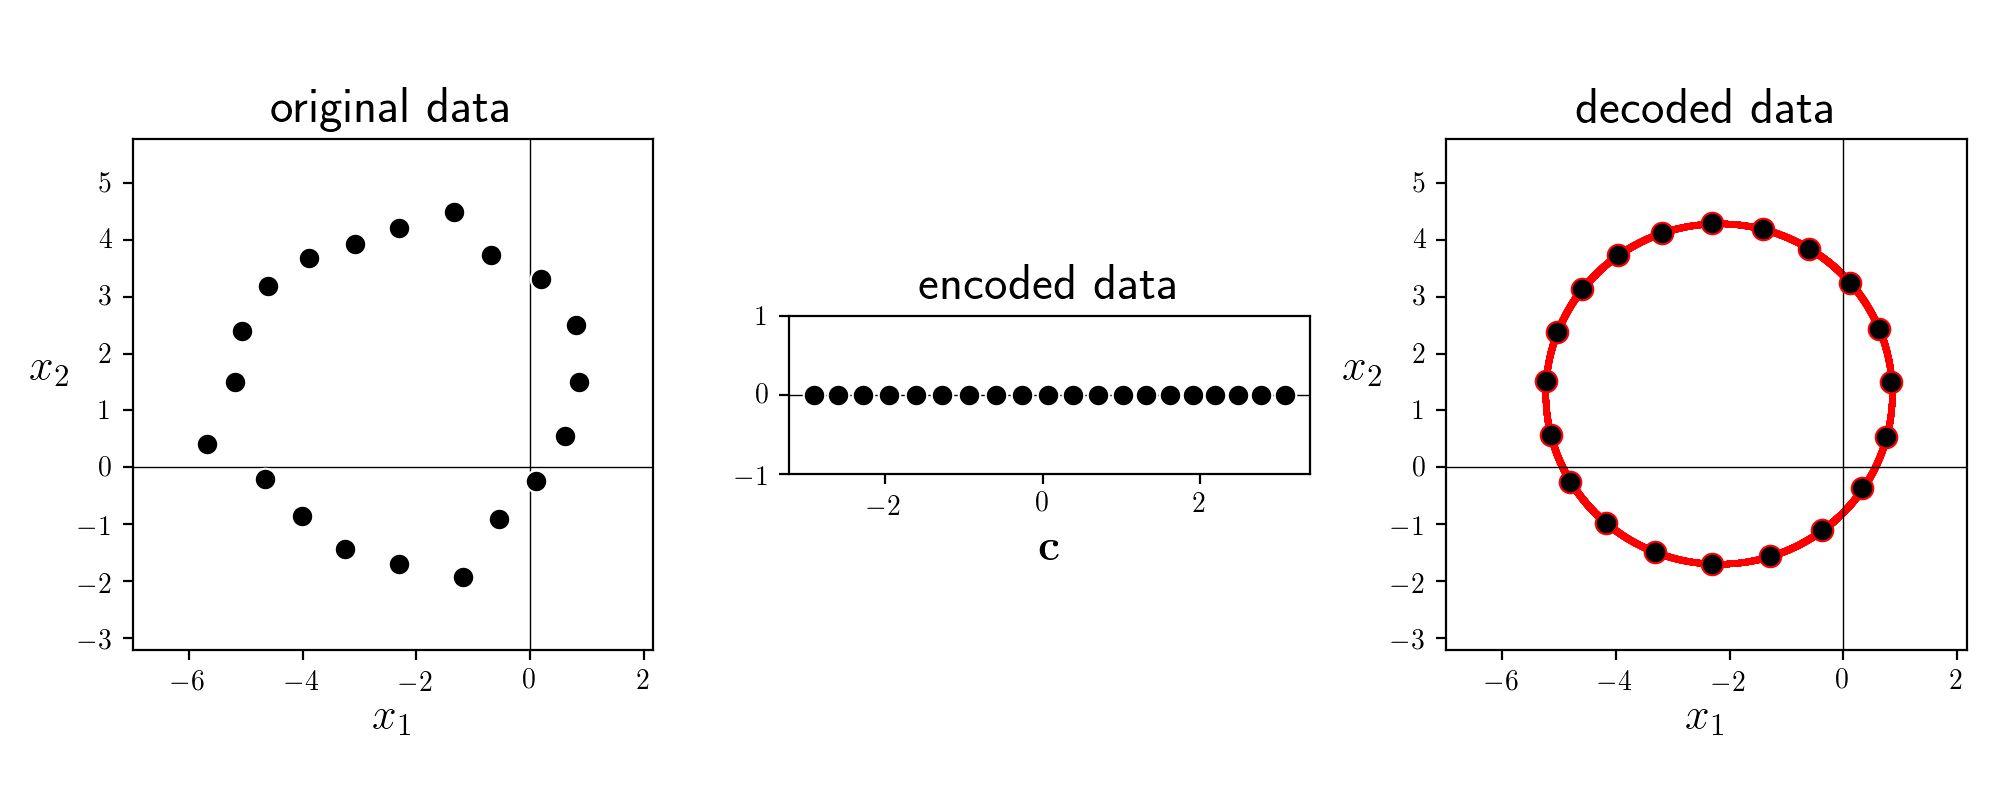

<IPython.core.display.Javascript object>


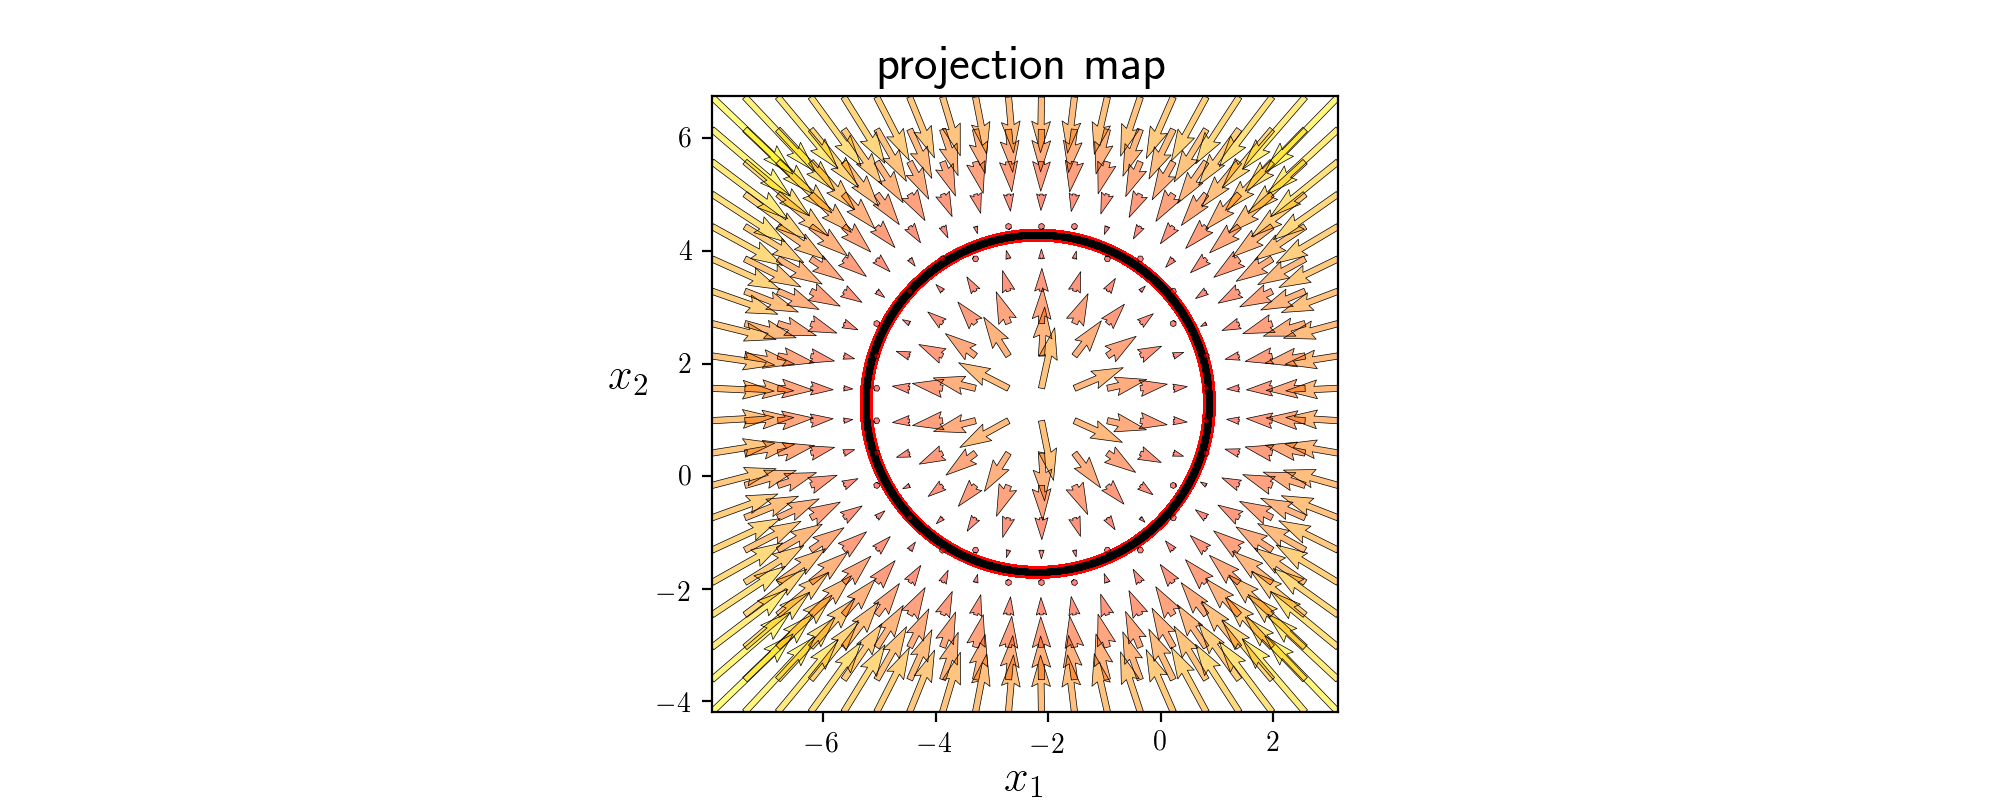

In [14]:
# plot results
unlib.autoencoder_demos.show_encode_decode(X,cost_history,weight_history,encoder=encoder,decoder=decoder,show_pc = False,scale = 55,encode_label = r'$\mathbf{c}$',projmap = True)